# Creating Custom Nodes in NeuroWorkflow

This notebook provides a step-by-step guide to creating custom nodes for the NeuroWorkflow library. We'll create a simple data filtering node to demonstrate the process.

## Setup

First, let's import the necessary components from the NeuroWorkflow library.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the Python path if needed
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import NeuroWorkflow components
from neuroworkflow import Node, NodeDefinitionSchema, WorkflowBuilder
from neuroworkflow.core.schema import PortDefinition, ParameterDefinition, MethodDefinition
from neuroworkflow.core.port import PortType

## Step 1: Planning Your Node

Before implementing a node, it's important to plan what it will do:

1. **Purpose**: Create a node that filters time series data using various methods
2. **Inputs**: Time series data (array of values)
3. **Outputs**: Filtered data, filter parameters
4. **Parameters**: Filter type, filter parameters
5. **Process Steps**: Load data, apply filter, return results

## Step 2: Creating the Node Definition

Let's define our `DataFilterNode` class with a proper `NODE_DEFINITION`:

In [2]:
# Define our custom DataFilterNode class
class DataFilterNode(Node):
    """Node for filtering time series data."""
    
    NODE_DEFINITION = NodeDefinitionSchema(
        type='data_filter',
        description='Filters time series data using various methods',
        
        # Define configurable parameters
        parameters={
            'filter_type': ParameterDefinition(
                default_value='moving_average',
                description='Type of filter to apply',
                constraints={'allowed_values': ['moving_average', 'gaussian', 'median', 'butterworth']}
            ),
            'window_size': ParameterDefinition(
                default_value=5,
                description='Window size for moving average and median filters',
                constraints={'min': 1, 'max': 1000}
            ),
            'sigma': ParameterDefinition(
                default_value=1.0,
                description='Standard deviation for Gaussian filter',
                constraints={'min': 0.1, 'max': 100.0}
            ),
            'cutoff_freq': ParameterDefinition(
                default_value=0.1,
                description='Cutoff frequency for Butterworth filter (normalized to Nyquist)',
                constraints={'min': 0.001, 'max': 0.999}
            ),
            'order': ParameterDefinition(
                default_value=4,
                description='Order for Butterworth filter',
                constraints={'min': 1, 'max': 10}
            )
        },
        
        # Define input ports
        inputs={
            'data': PortDefinition(
                type=PortType.OBJECT,  # We'll accept numpy arrays or lists
                description='Time series data to filter'
            ),
            'sampling_rate': PortDefinition(
                type=PortType.FLOAT,
                description='Sampling rate of the data (Hz)',
                optional=True  # This is optional
            )
        },
        
        # Define output ports
        outputs={
            'filtered_data': PortDefinition(
                type=PortType.OBJECT,
                description='Filtered time series data'
            ),
            'filter_info': PortDefinition(
                type=PortType.DICT,
                description='Information about the applied filter'
            )
        },
        
        # Define methods
        methods={
            'apply_filter': MethodDefinition(
                description='Apply the selected filter to the data',
                inputs=['data', 'sampling_rate'],
                outputs=['filtered_data', 'filter_info']
            )
        }
    )
    
    def __init__(self, name):
        """Initialize the DataFilterNode.
        
        Args:
            name: Name of the node
        """
        super().__init__(name)
        self._define_process_steps()
    
    def _define_process_steps(self):
        """Define the process steps for this node."""
        self.add_process_step(
            "apply_filter",
            self.apply_filter,
            method_key="apply_filter"
        )
    
    def apply_filter(self, data, sampling_rate=None):
        """Apply the selected filter to the data.
        
        Args:
            data: Time series data to filter (numpy array or list)
            sampling_rate: Sampling rate of the data (Hz), optional
            
        Returns:
            Dictionary with filtered data and filter information
        """
        # Convert data to numpy array if it's not already
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        
        # Get filter parameters
        filter_type = self._parameters['filter_type']
        window_size = self._parameters['window_size']
        sigma = self._parameters['sigma']
        cutoff_freq = self._parameters['cutoff_freq']
        order = self._parameters['order']
        
        print(f"Applying {filter_type} filter to data of length {len(data)}")
        
        # Apply the selected filter
        if filter_type == 'moving_average':
            filtered_data = self._apply_moving_average(data, window_size)
            filter_info = {
                'type': 'moving_average',
                'window_size': window_size
            }
        
        elif filter_type == 'gaussian':
            filtered_data = self._apply_gaussian(data, sigma)
            filter_info = {
                'type': 'gaussian',
                'sigma': sigma
            }
        
        elif filter_type == 'median':
            filtered_data = self._apply_median(data, window_size)
            filter_info = {
                'type': 'median',
                'window_size': window_size
            }
        
        elif filter_type == 'butterworth':
            if sampling_rate is None:
                print("Warning: No sampling rate provided for Butterworth filter. Using default of 1.0 Hz.")
                sampling_rate = 1.0
            
            filtered_data = self._apply_butterworth(data, cutoff_freq, order, sampling_rate)
            filter_info = {
                'type': 'butterworth',
                'cutoff_freq': cutoff_freq,
                'order': order,
                'sampling_rate': sampling_rate
            }
        
        else:
            raise ValueError(f"Unknown filter type: {filter_type}")
        
        # Add some statistics to the filter info
        filter_info.update({
            'original_mean': np.mean(data),
            'original_std': np.std(data),
            'filtered_mean': np.mean(filtered_data),
            'filtered_std': np.std(filtered_data)
        })
        
        return {
            'filtered_data': filtered_data,
            'filter_info': filter_info
        }
    
    def _apply_moving_average(self, data, window_size):
        """Apply moving average filter."""
        kernel = np.ones(window_size) / window_size
        return np.convolve(data, kernel, mode='same')

    def _apply_gaussian(self, data, sigma):
        """Apply Gaussian filter."""
        # Create Gaussian kernel
        window_size = int(6 * sigma)  # 3 sigma on each side
        if window_size % 2 == 0:
            window_size += 1  # Make sure it's odd
        
        x = np.linspace(-3*sigma, 3*sigma, window_size)
        kernel = np.exp(-0.5 * (x/sigma)**2)
        kernel = kernel / np.sum(kernel)  # Normalize
        
        return np.convolve(data, kernel, mode='same')

    def _apply_median(self, data, window_size):
        """Apply median filter."""
        from scipy.signal import medfilt
        # Make sure window_size is odd
        if window_size % 2 == 0:
            window_size += 1
        
        return medfilt(data, kernel_size=window_size)

    def _apply_butterworth(self, data, cutoff_freq, order, sampling_rate):
        """Apply Butterworth filter."""
        from scipy.signal import butter, filtfilt
        
        # Normalize cutoff frequency
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        
        # Create filter
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        
        # Apply filter
        return filtfilt(b, a, data)

## Step 3: Implementing Process Methods

Now, let's implement the methods that will process our data:

In [3]:
# The DataFilterNode class is now fully defined in the previous cell
# We can now create instances of it and use it in our workflows

## Step 4: Defining Process Steps

Now, let's implement the constructor and define the process steps:

In [4]:
# The DataFilterNode class is now fully defined with all its methods
# No need to add methods separately

## Step 5: Testing the Node

Now let's test our custom node with some sample data:

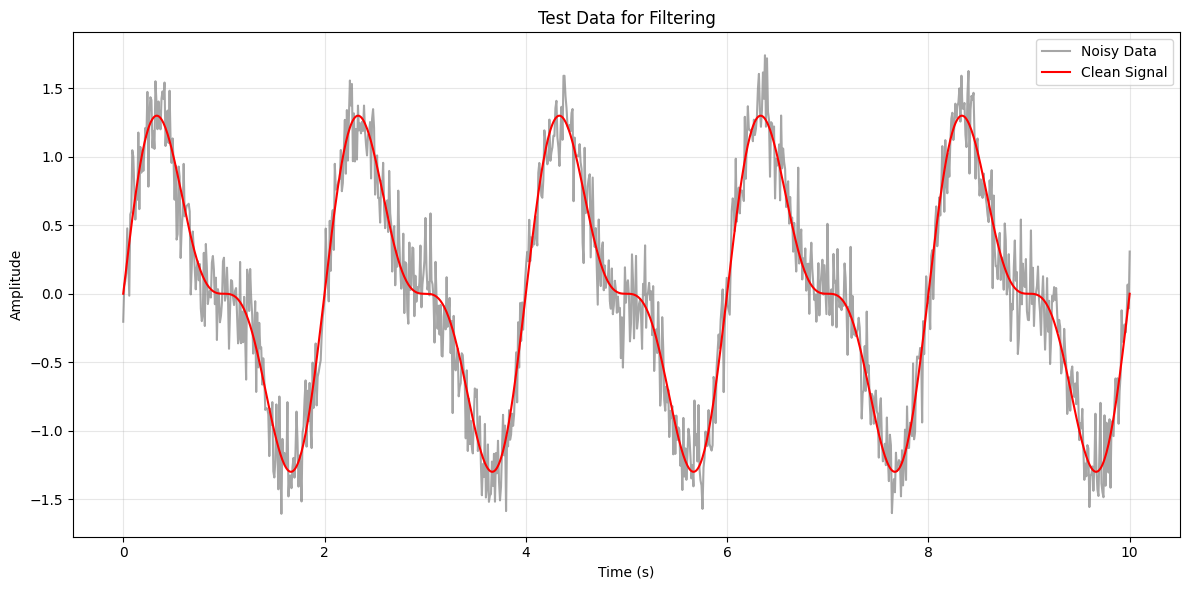

In [5]:
# Generate some noisy data for testing
def generate_test_data(n_samples=1000):
    """Generate noisy test data.
    
    Args:
        n_samples: Number of samples
        
    Returns:
        Tuple of (time, data, clean_data)
    """
    # Time vector
    t = np.linspace(0, 10, n_samples)
    
    # Clean signal (sum of sines)
    clean = np.sin(2 * np.pi * 0.5 * t) + 0.5 * np.sin(2 * np.pi * 1.0 * t)
    
    # Add noise
    noise = 0.2 * np.random.randn(n_samples)
    data = clean + noise
    
    return t, data, clean

# Generate test data
t, noisy_data, clean_data = generate_test_data(1000)

# Plot the test data
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_data, 'gray', alpha=0.7, label='Noisy Data')
plt.plot(t, clean_data, 'r', label='Clean Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Test Data for Filtering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Create a new instance of our custom DataFilterNode
filter_node = DataFilterNode("DataFilter")

# Print node information
print(filter_node)

Node: DataFilter (data_filter)
Description: Filters time series data using various methods
Parameters:
  filter_type: moving_average
  window_size: 5
  sigma: 1.0
  cutoff_freq: 0.1
  order: 4
Input Ports:
  data (object, required, not connected): Time series data to filter
  sampling_rate (float, optional, not connected): Sampling rate of the data (Hz)
Output Ports:
  filtered_data (object, not connected): Filtered time series data
  filter_info (dict, not connected): Information about the applied filter
Process Steps:
  apply_filter: Apply the selected filter to the data
    Inputs: data, sampling_rate
    Outputs: filtered_data, filter_info



Executing moving_average filter workflow...
Executing node: DataFilter
Applying moving_average filter to data of length 1000
Filter info: {'type': 'moving_average', 'window_size': 15, 'original_mean': 0.0011625452047448377, 'original_std': 0.8187881098296272, 'filtered_mean': 0.0010643158450777009, 'filtered_std': 0.7845264732355682}

Executing gaussian filter workflow...
Executing node: DataFilter
Applying gaussian filter to data of length 1000
Filter info: {'type': 'gaussian', 'sigma': 2.0, 'original_mean': 0.0011625452047448377, 'original_std': 0.8187881098296272, 'filtered_mean': 0.0011140182959958338, 'filtered_std': 0.7956991646729861}

Executing median filter workflow...
Executing node: DataFilter
Applying median filter to data of length 1000
Filter info: {'type': 'median', 'window_size': 11, 'original_mean': 0.0011625452047448377, 'original_std': 0.8187881098296272, 'filtered_mean': -0.0003673328437815613, 'filtered_std': 0.7963269411647429}

Executing butterworth filter workf

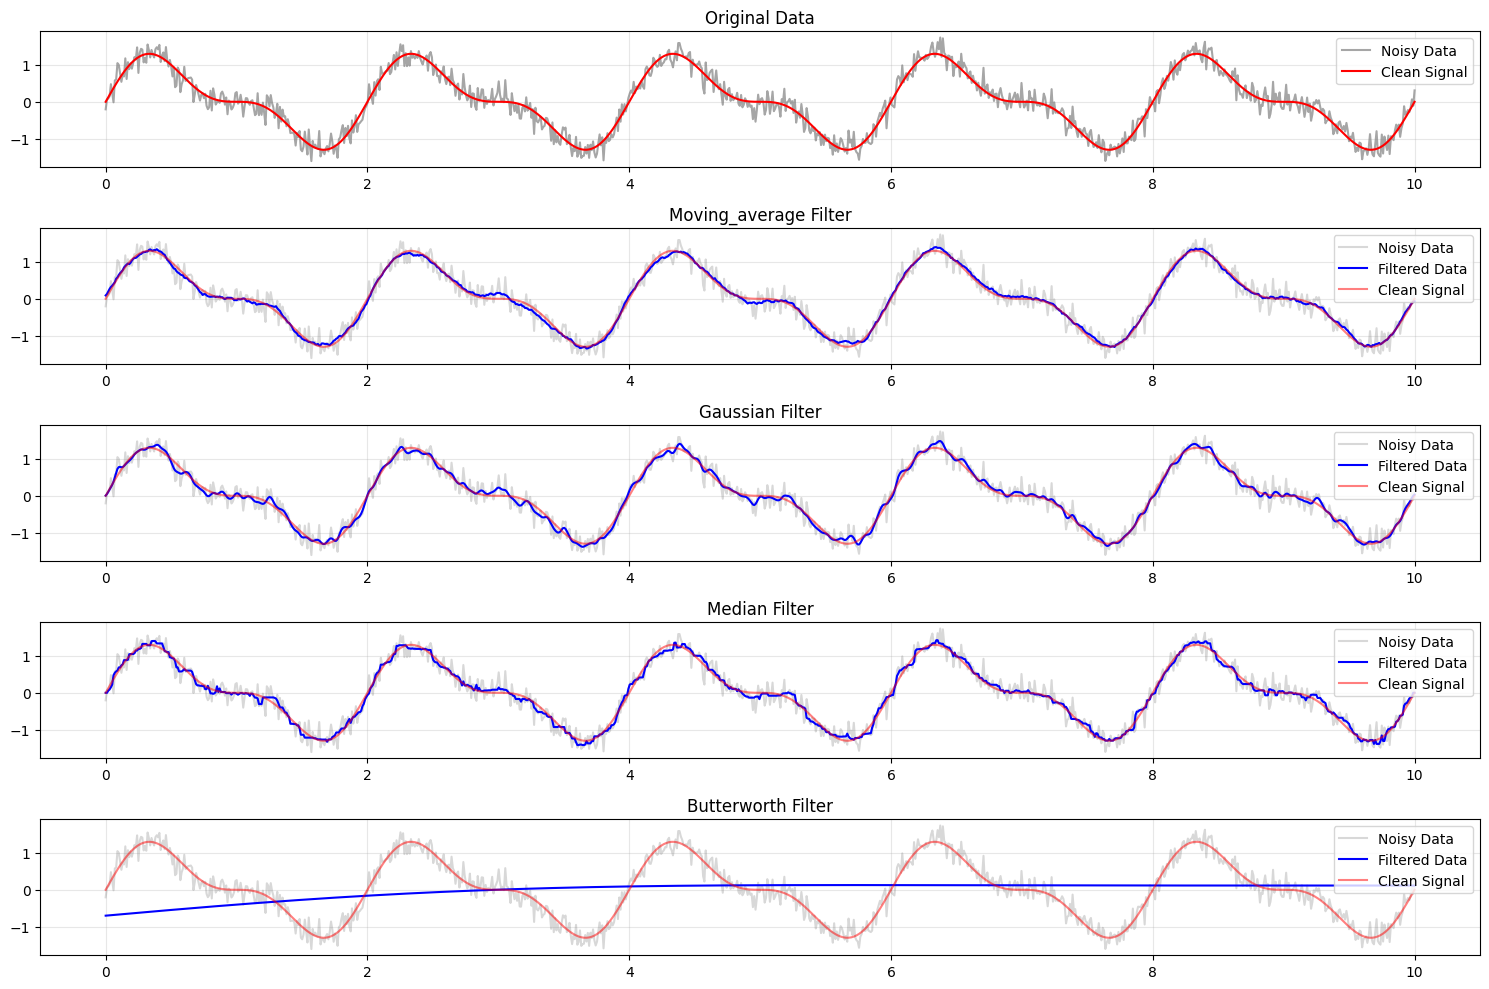

In [7]:
# Test different filter types
filter_types = ['moving_average', 'gaussian', 'median', 'butterworth']
results = {}

plt.figure(figsize=(15, 10))

# Plot original data
plt.subplot(len(filter_types) + 1, 1, 1)
plt.plot(t, noisy_data, 'gray', alpha=0.7, label='Noisy Data')
plt.plot(t, clean_data, 'r', label='Clean Signal')
plt.title('Original Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Create a workflow for each filter type
for i, filter_type in enumerate(filter_types, 1):
    # Configure the filter node
    if filter_type == 'moving_average':
        filter_node.configure(filter_type=filter_type, window_size=15)
    elif filter_type == 'gaussian':
        filter_node.configure(filter_type=filter_type, sigma=2.0)
    elif filter_type == 'median':
        filter_node.configure(filter_type=filter_type, window_size=11)
    elif filter_type == 'butterworth':
        filter_node.configure(filter_type=filter_type, cutoff_freq=0.1, order=4)
    
    # Create a workflow
    workflow = WorkflowBuilder(f"{filter_type}_workflow").add_node(filter_node).build()
    
    # Set input values
    filter_node.get_input_port("data").set_value(noisy_data)
    filter_node.get_input_port("sampling_rate").set_value(100.0)  # 100 Hz
    
    # Execute the workflow
    print(f"\nExecuting {filter_type} filter workflow...")
    success = workflow.execute()
    
    if success:
        # Get the results
        filtered_data = filter_node.get_output_port("filtered_data").value
        filter_info = filter_node.get_output_port("filter_info").value
        
        # Store results
        results[filter_type] = {
            'data': filtered_data,
            'info': filter_info
        }
        
        # Print filter info
        print(f"Filter info: {filter_info}")
        
        # Plot filtered data
        plt.subplot(len(filter_types) + 1, 1, i + 1)
        plt.plot(t, noisy_data, 'gray', alpha=0.3, label='Noisy Data')
        plt.plot(t, filtered_data, 'b', label='Filtered Data')
        plt.plot(t, clean_data, 'r', alpha=0.5, label='Clean Signal')
        plt.title(f'{filter_type.capitalize()} Filter')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        print(f"Workflow execution failed for {filter_type} filter!")

plt.tight_layout()
plt.show()

## Step 6: Evaluating Filter Performance

Let's compare the performance of different filters by calculating the mean squared error (MSE) between the filtered data and the clean signal:

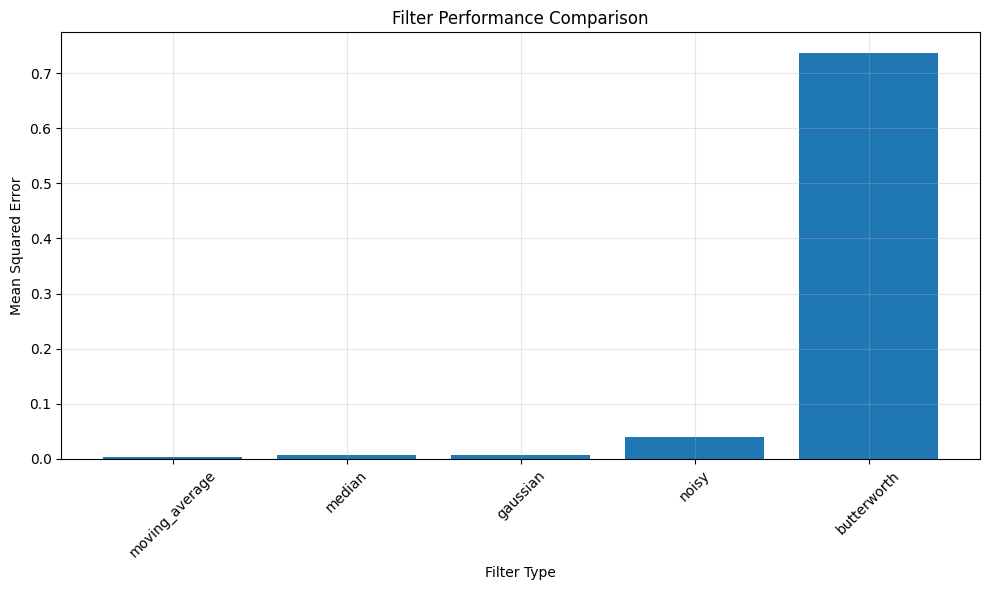

Mean Squared Error (lower is better):
  moving_average: 0.003313
  median: 0.006350
  gaussian: 0.006514
  noisy: 0.039842
  butterworth: 0.737460


In [8]:
# Calculate MSE for each filter
mse = {}
for filter_type, result in results.items():
    filtered_data = result['data']
    mse[filter_type] = np.mean((filtered_data - clean_data)**2)

# Calculate MSE for original noisy data
mse['noisy'] = np.mean((noisy_data - clean_data)**2)

# Plot MSE comparison
plt.figure(figsize=(10, 6))
filter_names = list(mse.keys())
mse_values = [mse[name] for name in filter_names]

# Sort by MSE
sorted_indices = np.argsort(mse_values)
sorted_names = [filter_names[i] for i in sorted_indices]
sorted_values = [mse_values[i] for i in sorted_indices]

plt.bar(range(len(sorted_names)), sorted_values)
plt.xticks(range(len(sorted_names)), sorted_names, rotation=45)
plt.xlabel('Filter Type')
plt.ylabel('Mean Squared Error')
plt.title('Filter Performance Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print MSE values
print("Mean Squared Error (lower is better):")
for name, value in zip(sorted_names, sorted_values):
    print(f"  {name}: {value:.6f}")

## Creating a More Complex Workflow

Now let's create a more complex workflow that combines multiple filter nodes:

In [9]:
# Create a new instance of DataFilterNode for moving average filter
# (This ensures we don't rely on variables from previous cells)
moving_avg_filter = DataFilterNode("MovingAverageFilter")
moving_avg_filter.configure(filter_type='moving_average', window_size=15)

# Create a new instance of DataFilterNode for Gaussian filter
gaussian_filter = DataFilterNode("GaussianFilter")
gaussian_filter.configure(filter_type='gaussian', sigma=2.0)

# Create a workflow builder
workflow_builder = WorkflowBuilder("multi_filter_workflow")

# Add nodes to the workflow
workflow_builder.add_node(moving_avg_filter)
workflow_builder.add_node(gaussian_filter)

# Connect the nodes (output of moving average to input of gaussian)
workflow_builder.connect(
    "MovingAverageFilter", "filtered_data", 
    "GaussianFilter", "data"
)

# Build the workflow
workflow = workflow_builder.build()

# Print workflow information
print(workflow)

Workflow: multi_filter_workflow
Nodes:
  MovingAverageFilter
  GaussianFilter
Connections:
  MovingAverageFilter.filtered_data -> GaussianFilter.data


Executing multi-filter workflow...
Executing node: MovingAverageFilter
Applying moving_average filter to data of length 1000
Executing node: GaussianFilter
Applying gaussian filter to data of length 1000


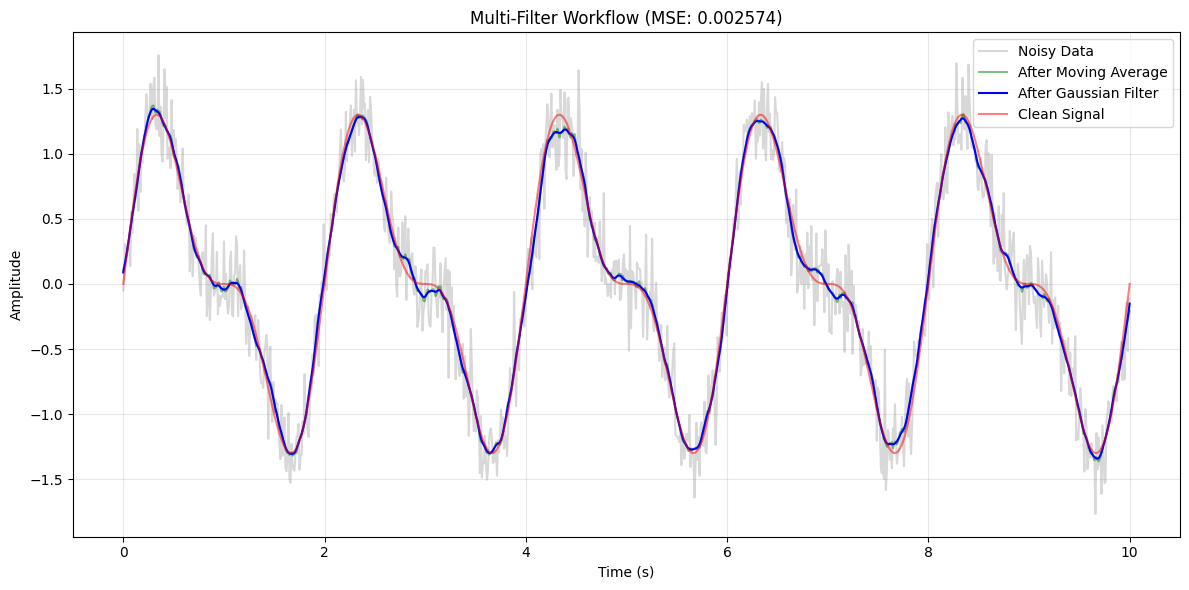


Multi-filter MSE: 0.002574
Moving Average MSE: 0.002949
Gaussian MSE: 0.002574
Noisy Data MSE: 0.039167


In [10]:
# Generate test data again to ensure it's available in this cell
t, noisy_data, clean_data = generate_test_data(1000)

# Set input values for the first node
moving_avg_filter.get_input_port("data").set_value(noisy_data)
moving_avg_filter.get_input_port("sampling_rate").set_value(100.0)

# Set sampling rate for the second node
gaussian_filter.get_input_port("sampling_rate").set_value(100.0)

# Execute the workflow
print("Executing multi-filter workflow...")
success = workflow.execute()

if success:
    # Get the results from the second node
    filtered_data = gaussian_filter.get_output_port("filtered_data").value
    
    # Calculate MSE
    mse_multi = np.mean((filtered_data - clean_data)**2)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(t, noisy_data, 'gray', alpha=0.3, label='Noisy Data')
    plt.plot(t, moving_avg_filter.get_output_port("filtered_data").value, 
             'g', alpha=0.5, label='After Moving Average')
    plt.plot(t, filtered_data, 'b', label='After Gaussian Filter')
    plt.plot(t, clean_data, 'r', alpha=0.5, label='Clean Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Multi-Filter Workflow (MSE: {mse_multi:.6f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nMulti-filter MSE: {mse_multi:.6f}")
    
    # Calculate MSE for individual filters for comparison
    # (This ensures we don't rely on variables from previous cells)
    mse_moving_avg = np.mean((moving_avg_filter.get_output_port("filtered_data").value - clean_data)**2)
    mse_gaussian = np.mean((filtered_data - clean_data)**2)
    mse_noisy = np.mean((noisy_data - clean_data)**2)
    
    print(f"Moving Average MSE: {mse_moving_avg:.6f}")
    print(f"Gaussian MSE: {mse_gaussian:.6f}")
    print(f"Noisy Data MSE: {mse_noisy:.6f}")
else:
    print("Workflow execution failed!")

## Conclusion

In this notebook, we've demonstrated how to:

1. Create a custom node by defining a `NODE_DEFINITION` schema
2. Implement processing methods for the node
3. Define process steps that link methods to the node definition
4. Test the node with sample data
5. Create a more complex workflow with multiple nodes

This example shows how the NeuroWorkflow library can be extended with custom nodes to perform specific tasks. The modular nature of the framework allows you to create complex workflows by connecting nodes together, with each node performing a specific part of the overall processing pipeline.